# Projet 10 — PDP & ICE avancés

Objectif: entraîner un modèle non linéaire puissant, tracer des courbes PDP et ICE sur 2–3 variables clés et montrer comment le PDP (moyenne globale) peut masquer des hétérogénéités locales que l’ICE révèle.

---

## Plan rapide

1) Charger un dataset tabulaire (ex: Adult Income via OpenML).  
2) Prétraiter (One-Hot pour catégorielles, imputation).  
3) Entraîner un modèle non linéaire (Random Forest, Gradient Boosting, XGBoost).  
4) Identifier 2–3 variables clés (importance/permutation, SHAP en option).  
5) Tracer:
   - PDP 1D (moyenne) et ICE 1D (courbes individuelles) pour chaque variable,
   - PDP 2D pour au moins une paire pour voir les interactions,
   - Option: ICE centré (c-ICE) et ICE coloré par une autre variable pour mettre en évidence l’hétérogénéité.
6) Interpréter et documenter les comportements moyens vs individuels.


---

## Dataset proposé

- Adult Income (classification binaire: >50K$): accessible directement via scikit-learn/OpenML; riche en variables numériques et catégorielles, avec interactions plausibles (âge × heures, éducation × heures, etc.).

Alternatives:
- California Housing (régression) pour un exemple purement numérique.
- Ames Housing (régression) via OpenML si vous préférez un « House Prices » libre (évite Kaggle).

Ci-dessous, un flux de travail complet sur Adult Income.

---

## Implémentation (Python)

Pré-requis: scikit-learn ≥ 1.1, matplotlib, pandas, numpy.  
Optionnel: xgboost si vous préférez XGBoost.


### 2) Choie 2–3 variables clés

Option 1 (rapide): permutation importance sur l’échantillon de test.

Variables  intéressantes sur Adult: "age", "hours-per-week", "education-num".  
Nous allons les utiliser pour PDP/ICE.

### 3) PDP et ICE 1D

Lecture:
- La courbe épaisse = PDP (effet moyen conditionnel).  
- Les nombreuses courbes fines = ICE (variations au niveau de chaque individu, toutes choses égales par ailleurs sur la grille de la feature).

### 4) PDP 2D (interactions)

Lecture:
- Les cartes 2D et les courbes de niveau révèlent des interactions (ex: l’effet des heures dépend du niveau d’éducation).

### 5) ICE centré et hétérogénéité par sous-groupes (c-ICE + coloration)

Le centrage met en évidence les différences de pente plutôt que les niveaux.

Lecture:
- Si les moyennes par quantile d’éducation divergent nettement, l’effet des heures est hétérogène selon l’éducation (interaction implicite).  
- Le PDP 1D pouvait être lisse, mais les c-ICE révèlent des différences de pente/seuils entre sous-groupes.

---



## En une phrase

- PDP résume l’effet moyen du modèle; ICE montre la diversité des comportements individuels.  
- Conclusion à illustrer: « Le PDP peut lisser des effets hétérogènes que l’ICE (et c-ICE) met en évidence, et les PDP 2D confirment les interactions responsables de ces hétérogénéités. »

# Chargement et préparation


In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# 1) Charger Adult Income
adult = fetch_openml(name="adult", as_frame=True)
df = adult.frame.copy()

# Cible binaire: 1 si >50K
y = (df["class"] == ">50K").astype(int)
X = df.drop(columns=["class"])

# Gardons 'education-num' et supprimons 'education' pour éviter la fuite d'information.
if "education" in X.columns:
    X = X.drop(columns=["education"])

# Explicitly convert columns that should be numeric but might be object type
numeric_like_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


# This assumes column names are consistent: age, fnlwgt, education-num, capitalgain, capitalloss, hoursperweek
actual_numeric_cols_in_X = ['age', 'fnlwgt', 'education-num', 'capitalgain', 'capitalloss', 'hoursperweek']

for col in actual_numeric_cols_in_X:
    if col in X.columns:
        # Convert to numeric, coercing errors to NaN, which SimpleImputer can then handle
        X[col] = pd.to_numeric(X[col], errors='coerce')

# 2) Colonnes numériques / catégorielles
# Re-select after conversion to ensure correct dtypes
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

# 3) Prétraitements
num_pre = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Pour scikit-learn >=1.2, utilisez sparse_output=False (sinon 'sparse=False')
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
cat_pre = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

preprocess = ColumnTransformer([
    ("num", num_pre, num_cols),
    ("cat", cat_pre, cat_cols)
])

# 4) Modèle non linéaire (facile et performant)
clf = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

pipe = Pipeline([
    ("prep", preprocess),
    ("model", clf)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

pipe.fit(X_train, y_train)
print("Score (ROC-AUC approximatif via predict_proba):")


/usr/local/lib/python3.12/dist-packages/sklearn/datasets/_openml.py:323: UserWarning: Multiple active versions of the dataset matching the name adult exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=179
- version 2, status: active
  url: https://www.openml.org/search?type=data&id=1590

  warn(warning_msg)


Score (ROC-AUC approximatif via predict_proba):


In [8]:
print(X.head(5))
print(y.head(5))

   age         workclass  fnlwgt  education-num      marital-status  \
0    2         State-gov   77516             13       Never-married   
1    3  Self-emp-not-inc   83311             13  Married-civ-spouse   
2    2           Private  215646              9            Divorced   
3    3           Private  234721              7  Married-civ-spouse   
4    1           Private  338409             13  Married-civ-spouse   

          occupation   relationship   race     sex  capitalgain  capitalloss  \
0       Adm-clerical  Not-in-family  White    Male            1            0   
1    Exec-managerial        Husband  White    Male            0            0   
2  Handlers-cleaners  Not-in-family  White    Male            0            0   
3  Handlers-cleaners        Husband  Black    Male            0            0   
4     Prof-specialty           Wife  Black  Female            0            0   

   hoursperweek native-country  
0             2  United-States  
1             0  United-St

1. **Observation Importante :**

Discrétisation des Données
Les colonnes numériques age, capitalgain, et hoursperweek contiennent des valeurs très faibles (1, 2, 3, 0).

* Age : Une personne ne travaille pas à "2" ans. Ces chiffres représentent des catégories ou des bins (intervalles). Par exemple, 1 pourrait signifier "Jeune (17-25)", 2 "Adulte (26-45)", etc.

* Hoursperweek : La valeur "0" pour un cadre (Exec-managerial) est impossible dans la réalité brute. Cela représente probablement une tranche d'heures (ex: "Temps partiel" ou "Faible volume").

* Capitalgain : "1" est un code, pas une valeur en dollars.

2. **Analyse des Colonnes (Features)**

Voici la signification des variables affichées :

* Démographie :

  - age : L'âge de l'individu (ici encodé en catégories : 1, 2, 3).

  - race & sex : L'origine ethnique et le genre (ex: White/Male, Black/Female).

  - native-country : Le pays d'origine (ex: United-States, Cuba).

  - marital-status & relationship : État civil et rôle familial. Par exemple, la ligne 1 est un "Marié-civ-spouse" (marié civilement) et son rôle est "Husband" (Mari).

* Socio-économique :

  - workclass : Le type d'employeur.

    - State-gov : Employé de l'État.

    - Self-emp-not-inc : Auto-entrepreneur (non incorporé).

    - Private : Secteur privé.

  - education-num : Le niveau d'éducation numérique. C'est une donnée ordinale très utile :

    - 13 = Bachelor (Licence).

    - 9 = HS-grad (Lycée).

    - 7 = 11th grade (Première).

  - occupation : Le type de poste (ex: Adm-clerical pour administratif, Exec-managerial pour cadre).

  - fnlwgt (Final Weight) : Une estimation statistique du nombre de personnes que cette ligne représente dans la population réelle. C'est un poids d'échantillonnage utilisé par le bureau de recensement, souvent ignoré par les modèles de ML simples car il n'est pas prédictif du revenu individuel direct.

- Financier :

  - capitalgain / capitalloss : Les gains ou pertes en capital (investissements), ici encodés.

3. **La Cible (Target Variable)**

- Tout en bas, vous avez la série Name: class.

  - 0 : C'est la variable que le modèle doit prédire.

  - Dans ce dataset, 0 correspond généralement à un revenu annuel <= 50K$ (inférieur ou égal à 50 000 dollars).

  - La valeur 1 correspondrait à > 50K$.

# XGBOOST

In [2]:
# pip install xgboost
from xgboost import XGBClassifier
clf = XGBClassifier(
    n_estimators=800, max_depth=6, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, random_state=42,
    n_jobs=-1, tree_method="hist", eval_metric="logloss"
)
pipe = Pipeline([("prep", preprocess), ("model", clf)])
pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capitalgain', 'capitalloss',
                                                   'hoursperweek']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=800, n_jobs=-1,
                               num_parallel_tree=None, ...))])

# Choix de variables cles

In [3]:
from sklearn.inspection import permutation_importance

r = permutation_importance(pipe, X_test, y_test, n_repeats=10, random_state=42, scoring="roc_auc")
# Les noms côté entrée (avant OHE) restent ceux de X
imp = pd.Series(r.importances_mean, index=X_test.columns).sort_values(ascending=False)
print(imp.head(10))

marital-status    0.074573
capitalgain       0.045587
education-num     0.035291
age               0.025924
occupation        0.016984
hoursperweek      0.015351
relationship      0.009346
capitalloss       0.005033
workclass         0.003256
sex               0.002644
dtype: float64


In [9]:
imp

,0
marital-status,0.074573
capitalgain,0.045587
education-num,0.035291
age,0.025924
occupation,0.016984
hoursperweek,0.015351
relationship,0.009346
capitalloss,0.005033
workclass,0.003256
sex,0.002644


# PDP et ICE 1D

Nous allons utilisé ces 3 variables ["age", "hoursperweek", "education-num"] car ils sont les plus utilisés et importants pour ce dataset

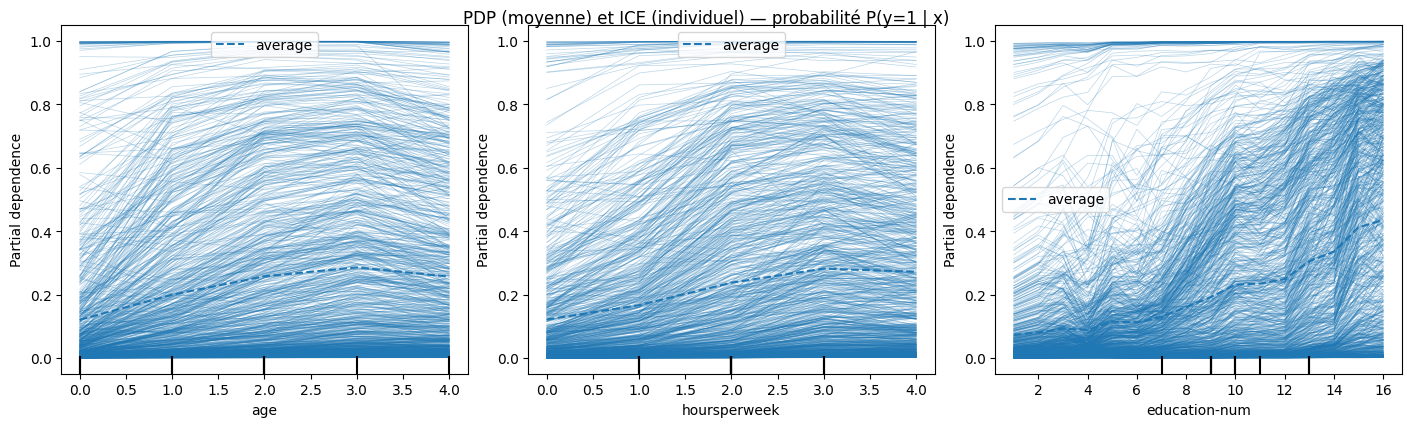

In [5]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

features_1d = ["age", "hoursperweek", "education-num"]

# kind="both" = PDP (moyenne) + ICE (individuel)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    pipe, X_test, features=features_1d,
    kind="both", grid_resolution=30, target=1, ax=ax
)
fig.suptitle("PDP (moyenne) et ICE (individuel) — probabilité P(y=1 | x)", y=1.03)
plt.show()

## Interprétation :

### 1. Variable `age` (Graphique de gauche)
* **Ce qu'on voit :** L'axe X montre l'âge (encodé en catégories 0-4). La ligne pointillée (moyenne) monte progressivement jusqu'au niveau 3 avant de redescendre légèrement au niveau 4.
* **Interprétation métier :** La probabilité de gagner >50K augmente avec l'âge, ce qui est logique (gain d'expérience). Cependant, le léger déclin à la fin (niveau 4) suggère que pour la tranche d'âge la plus élevée (probablement la retraite), les revenus tendent à baisser ou stagner.
* **Les lignes fines (ICE) :** On voit que les lignes sont assez parallèles. Cela signifie que l'âge a un effet similaire sur tout le monde, quel que soit leur niveau de base.

### 2. Variable `hoursperweek` (Graphique du milieu)
* **Ce qu'on voit :** L'axe X représente les heures travaillées (encodées 0-4). La tendance moyenne monte clairement jusqu'au niveau 3.
* **Interprétation métier :** Plus on travaille d'heures, plus la probabilité d'avoir un haut revenu augmente. C'est une relation assez linéaire et positive.
* **Détail intéressant :** Notez que la courbe s'aplatit ou baisse un peu après 3. Cela peut indiquer que travailler un nombre d'heures extrême n'augmente plus nécessairement la probabilité d'être dans la classe "riche" (peut-être des emplois à bas salaire nécessitant beaucoup d'heures).

### 3. Variable `education-num` (Graphique de droite)
* **Ce qu'on voit :** L'axe X va de 1 à 16 (années d'études). C'est ici que l'effet est le plus spectaculaire. La courbe moyenne reste plate et basse au début, puis grimpe en flèche à partir de 9-10 (fin du lycée) et surtout après 12-13 (études supérieures).
* **Interaction forte (Désordre des lignes) :** Contrairement à l'âge où les lignes étaient bien rangées, ici c'est le chaos ("spaghetti plot"). Certaines lignes montent très vite, d'autres restent plates.
    * *Signification :* L'éducation ne profite pas à tout le monde de la même façon. Pour certains profils (probablement ceux avec de bonnes carrières par ailleurs), un diplôme supplémentaire fait exploser leur probabilité de richesse. Pour d'autres, l'impact est plus faible.

### Résumé Global
Le modèle a appris que :
1.  **L'éducation** est le facteur le plus déterminant (la pente la plus raide).
2.  L'effet de l'**âge** et des **heures de travail** est positif mais plafonne à un certain point.
3.  Le modèle est **non-linéaire** : il capture bien les effets de seuil (comme le saut de revenu grâce aux études supérieures).


# PDP 2D (interactions)

<Figure size 1000x800 with 0 Axes>

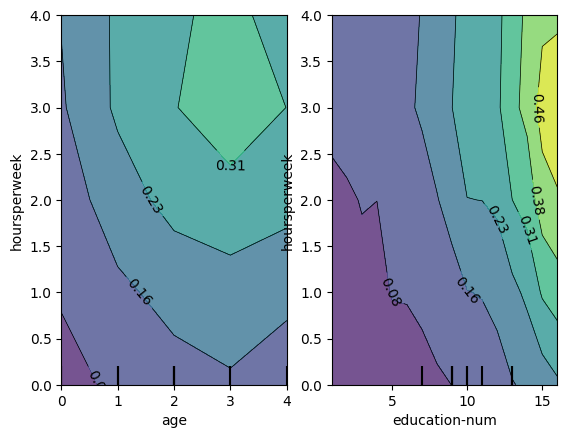

In [6]:
pairs_2d = [("age", "hoursperweek"),
            ("education-num", "hoursperweek")]

fig = plt.figure(figsize=(10, 8))
disp = PartialDependenceDisplay.from_estimator(
    pipe, X_test, features=pairs_2d,
    kind="average", grid_resolution=30, target=1
)
fig.suptitle("PDP 2D — interactions", y=1.02)
plt.show()

## Interpretation

Un **PDP 2D** montre l’effet moyen **combiné** de deux variables sur la **probabilité prédite d’avoir un revenu > 50K**, toutes les autres variables étant moyennées.

Les valeurs inscrites (ex : 0.16, 0.31, 0.46…) correspondent donc à une **probabilité prédite**.


## PDP âge × heures travaillées par semaine (graphique de gauche)

### Tendances principales

* **Âge ↑ ⇒ revenu ↑**

  * Plus l’âge augmente, plus la probabilité de dépasser 50K augmente.
  * Effet particulièrement visible après ~30–40 ans (selon l’échelle normalisée).

* **Heures/semaine ↑ ⇒ revenu ↑**

  * Travailler plus d’heures par semaine augmente clairement la probabilité.
  * Les faibles heures (0–20h) sont associées à de très faibles probabilités (< 0.1).

### Effet combiné (interaction)

* **Jeune + peu d’heures**
  → probabilité très faible (~0.05–0.1)

* **Âge moyen + heures élevées**
  → probabilité intermédiaire (~0.25–0.3)

* **Âgé + beaucoup d’heures**
  → probabilité maximale (~0.3+)

 **Conclusion** :
L’âge et les heures travaillées ont un **effet complémentaire**.
L’un sans l’autre n’est pas suffisant :

* être âgé mais peu travailler
* ou travailler beaucoup mais être très jeune
  donne des probabilités moyennes seulement.

---

## PDP niveau d’éducation × heures travaillées (graphique de droite)

### Tendances principales

* **Niveau d’éducation ↑ ⇒ revenu ↑ (effet fort)**

  * C’est l’un des effets les plus marqués du dataset Adult.
  * On passe d’environ **0.08** à **0.46** selon le niveau d’éducation.

* **Heures/semaine ↑ ⇒ revenu ↑**

  * Même effet positif que précédemment, mais **moins fort que l’éducation**.

### Effet combiné (interaction très claire)

* **Faible éducation + peu d’heures**
  → probabilité très faible (~0.05–0.1)

* **Éducation élevée + peu d’heures**
  → probabilité déjà significative (~0.25)

* **Éducation élevée + beaucoup d’heures**
  → probabilité maximale (~0.45–0.5)

 **Conclusion** :
L’éducation **amplifie fortement** l’effet des heures travaillées.
Travailler beaucoup **n’est réellement rentable** (en termes de revenu >50K) que si le niveau d’éducation est élevé.

---

## Comparaison des deux PDP

| Interaction        | Importance     |
| ------------------ | -------------- |
| âge × heures       | modérée        |
| éducation × heures | **très forte** |

 **L’éducation est plus discriminante que l’âge** dans la prédiction du revenu élevé.

---

## Lecture métier (intuitive)

* Le modèle apprend que :

  * Les **emplois qualifiés** (haut niveau d’éducation) paient mieux même à temps modéré
  * Les **emplois peu qualifiés** nécessitent beaucoup d’heures pour atteindre un revenu élevé
  * L’âge reflète surtout l’**expérience**, mais reste secondaire face au capital éducatif

---

## Synthèse

> *Le PDP 2D montre que le revenu élevé (>50K) dépend fortement du niveau d’éducation, dont l’effet est amplifié par le nombre d’heures travaillées. L’âge a un impact positif mais plus progressif, et ne compense pas un faible niveau d’éducation.*



# ICE centré et hétérogénéité par sous-groupes (c-ICE + coloration)

## c ICE centré a 40H

/tmp/ipython-input-1533801247.py:35: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(); plt.show()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


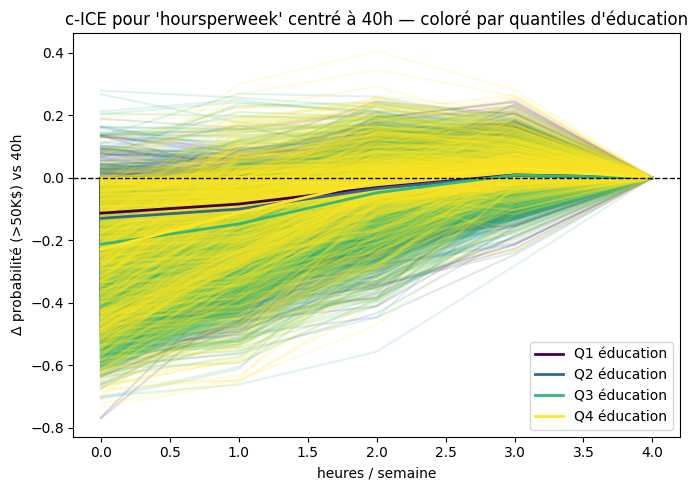

In [7]:
from sklearn.inspection import partial_dependence

feat = "hoursperweek"
res = partial_dependence(
    pipe, X=X_test, features=[feat],
    kind="individual", grid_resolution=40
)
xs = res.grid_values[0]                 # grille
lines = res["individual"][0]          # (n_samples, len(xs))

# c-ICE: centre chaque courbe à 40h/semaine (ou au point médian le plus proche)
center_val = 40
center_idx = np.argmin(np.abs(xs - center_val))
lines_centered = lines - lines[:, [center_idx]]

# Colorer par quantiles d'"education-num" (hétérogénéité)
edu = X_test["education-num"].astype(float)
groups = pd.qcut(edu, q=5, labels=False, duplicates="drop")

plt.figure(figsize=(7, 5))
cmap = plt.cm.viridis
for g in np.unique(groups):
    mask = (groups == g).values
    color = cmap(g / np.max(groups))
    plt.plot(xs, lines_centered[mask].T, color=color, alpha=0.15)
# moyenne par groupe (plus lisible)
for g in np.unique(groups):
    mask = (groups == g).values
    color = cmap(g / np.max(groups))
    plt.plot(xs, lines_centered[mask].mean(axis=0), color=color, lw=2, label=f"Q{int(g)+1} éducation")
plt.axhline(0, color="k", lw=1, ls="--")
plt.title("c-ICE pour 'hoursperweek' centré à 40h — coloré par quantiles d'éducation")
plt.xlabel("heures / semaine"); plt.ylabel("Δ probabilité (>50K$) vs 40h")
plt.legend()
plt.tight_layout(); plt.show()

### Interpretation

* **Axe x** : heures travaillées par semaine (normalisées / discrétisées)
* **Axe y** :
  Δ *probabilité(revenu > 50K)* **par rapport à 40 h**

  * 0 → équivalent à travailler 40 h
  * inf a 0 → moins favorable que 40 h
  * sup a 0 → plus favorable que 40 h
* **Chaque courbe fine** = un individu
* **Courbes épaisses** = moyenne par **quantile d’éducation (Q1 → Q4)**
* **Centrage à 40 h** → toutes les courbes passent par 0 à 40 h (référence)


## Effet global des heures travaillées

### Tendance moyenne (tous profils)

* **< 40 h**
  → forte baisse de la probabilité (>50K)
  → souvent **–0.2 à –0.6**

* **≈ 40 h**
  → point neutre (référence)

* **> 40 h**
  → **gain marginal faible**
  → les courbes plafonnent très vite

 **Interprétation clé** :
Travailler **moins que 40 h pénalise fortement**,
travailler **plus que 40 h rapporte peu**.


## Hétérogénéité individuelle (ce que révèle l’ICE)

* Forte **dispersion** des courbes :

  * pour certains individus, passer de 40 h à 20 h = –0.2
  * pour d’autres = –0.6 ou pire
* Cela indique une **interaction forte avec d’autres variables**
  (éducation, type d’emploi, âge, etc.)

 Justification de l’usage de ICE plutôt que PDP seul.


## Rôle de l’éducation (quantiles Q1 → Q4)

### Q1 – Éducation faible

* Courbe très négative en dessous de 40 h
* Forte dépendance aux heures travaillées
* Travailler moins = **forte chute de revenu potentiel**

### Q4 – Éducation élevée

* Courbe plus plate
* Moins sensible à la réduction d’heures
* Le capital éducatif **compense partiellement** le temps de travail

 **Effet d’interaction clair** :

> *Les heures travaillées sont beaucoup plus critiques pour les individus peu éduqués.*



## Asymétrie importante

* **Perdre des heures (<40h)**
  → effet négatif **fort**
* **Gagner des heures (>40h)**
  → effet positif **faible ou nul**



## Synthèse

> *Le c-ICE centré à 40 h montre un effet fortement asymétrique des heures travaillées sur la probabilité de revenu élevé. Une réduction du temps de travail en-dessous de 40 h entraîne une baisse significative, particulièrement pour les individus peu éduqués, tandis que l’augmentation au-delà de 40 h produit des gains marginaux limités.*


## c ICE centré a 0H

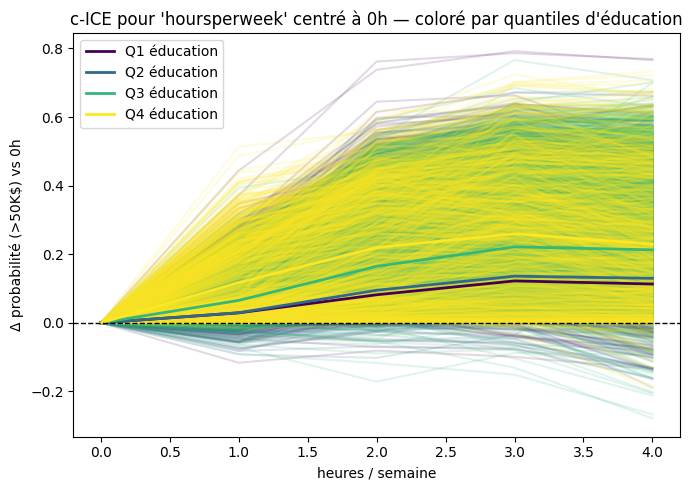

In [10]:
from sklearn.inspection import partial_dependence

feat = "hoursperweek"
res = partial_dependence(
    pipe, X=X_test, features=[feat],
    kind="individual", grid_resolution=40
)
xs = res.grid_values[0]                 # grille
lines = res["individual"][0]          # (n_samples, len(xs))

# c-ICE: centre chaque courbe à 0h/semaine (ou au point médian le plus proche)
center_val = 0
center_idx = np.argmin(np.abs(xs - center_val))
lines_centered = lines - lines[:, [center_idx]]

# Colorer par quantiles d'"education-num" (hétérogénéité)
edu = X_test["education-num"].astype(float)
groups = pd.qcut(edu, q=5, labels=False, duplicates="drop")

plt.figure(figsize=(7, 5))
cmap = plt.cm.viridis
for g in np.unique(groups):
    mask = (groups == g).values
    color = cmap(g / np.max(groups))
    plt.plot(xs, lines_centered[mask].T, color=color, alpha=0.15)
# moyenne par groupe (plus lisible)
for g in np.unique(groups):
    mask = (groups == g).values
    color = cmap(g / np.max(groups))
    plt.plot(xs, lines_centered[mask].mean(axis=0), color=color, lw=2, label=f"Q{int(g)+1} éducation")
plt.axhline(0, color="k", lw=1, ls="--")
plt.title("c-ICE pour 'hoursperweek' centré à 0h — coloré par quantiles d'éducation")
plt.xlabel("heures / semaine"); plt.ylabel("Δ probabilité (>50K$) vs 0h")
plt.legend()
plt.tight_layout(); plt.show()

# Variante rapide (régression California Housing)

In [11]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from xgboost import XGBRegressor
from sklearn.inspection import partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt

## Data Loading - California Housing

In [12]:
data = fetch_california_housing(as_frame=True)
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
y.head(5)

## Random Forest

In [13]:
reg = Pipeline([
    ("prep", ColumnTransformer([
        ("num", Pipeline([("imputer", SimpleImputer()), ("scaler", StandardScaler())]),
         X.columns)
    ])),
    ("rf", RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1))
]).fit(X_train, y_train)

## PDP & ICE

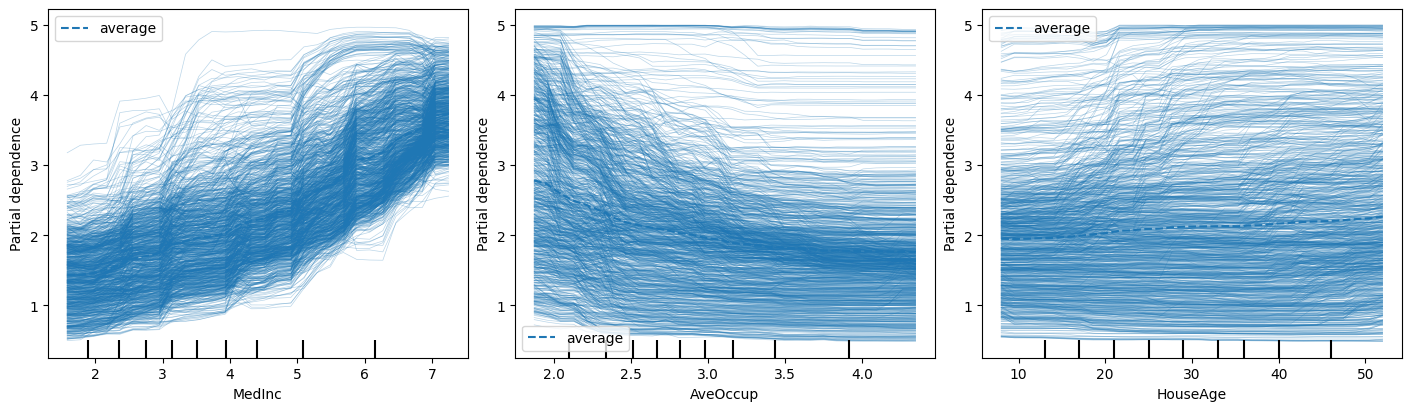

In [18]:
features = ["MedInc", "AveOccup", "HouseAge"]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4), constrained_layout=True)
PartialDependenceDisplay.from_estimator(reg, X_test, features=features, kind="both", grid_resolution=30, target=1, ax=ax)
plt.show()

### Interpretation

##  `MedInc` (Median Income) — graphique de gauche

### Effet moyen (PDP)

* **Relation fortement croissante et quasi monotone**
* Quand `MedInc` augmente, la valeur prédite du logement augmente fortement
* C’est **la variable la plus explicative** du modèle

### ICE (hétérogénéité)

* Courbes globalement **parallèles et ascendantes**
* Peu de croisements → effet **stable** pour la majorité des individus
* Légère non-linéarité :

  * pente plus forte au-delà de ~4–5
  * possible saturation pour les très hauts revenus

 **Interprétation**

> À localisation, âge et type de logement comparables, une hausse du revenu médian du quartier entraîne systématiquement une hausse du prix du logement.


##  `AveOccup` (Average Occupancy) — graphique central

### Effet moyen (PDP)

* **Relation décroissante**
* Plus le nombre moyen d’occupants par logement est élevé, plus la valeur prédite diminue

### ICE (forte hétérogénéité)

* Très forte dispersion des courbes
* Certaines observations :

  * chute rapide des prix avec l’occupation
  * d’autres presque insensibles

 Indique des **interactions importantes** avec :

* localisation (coastal vs inland)
* taille des logements
* revenu

 **Interprétation**

> Une forte densité d’occupation est en moyenne associée à des logements moins chers, mais cet effet dépend fortement du contexte socio-géographique.


##  `HouseAge` — graphique de droite

### Effet moyen (PDP)

* **Effet faible et légèrement positif**
* Courbe quasi plate autour de ~2.0–2.2

### ICE (structure en éventail)

* Certaines maisons anciennes :

  * valeur plus élevée (quartiers historiques)
* D’autres :

  * pas d’effet ou effet négatif

 Effet **non monotone et très dépendant du quartier**

 **Interprétation**

> L’âge du logement, pris isolément, n’est pas un déterminant majeur du prix ; il reflète surtout des effets de localisation et de standing non observés.


## Comparaison des variables

| Variable | Effet moyen | Hétérogénéité | Importance |
| -------- | ----------- | ------------- | ---------- |
| MedInc   | fort +      | faible        | ⭐⭐⭐⭐⭐      |
| AveOccup | négatif     | très forte    | ⭐⭐⭐        |
| HouseAge | faible      | forte         | ⭐⭐         |


## Synthèse

* Le modèle est **principalement socio-économique**
* `MedInc` domine clairement la prédiction
* Les autres variables agissent surtout comme **modulateurs locaux**
* ICE ≫ PDP pour comprendre les **cas extrêmes**

> *Les courbes ICE montrent que le revenu médian du quartier (`MedInc`) exerce un effet monotone et dominant sur la valeur des logements, tandis que l’occupation moyenne (`AveOccup`) et l’âge des maisons (`HouseAge`) présentent des effets plus faibles et fortement hétérogènes, révélant des interactions spatiales et socio-économiques importantes.*


## PDP 2D

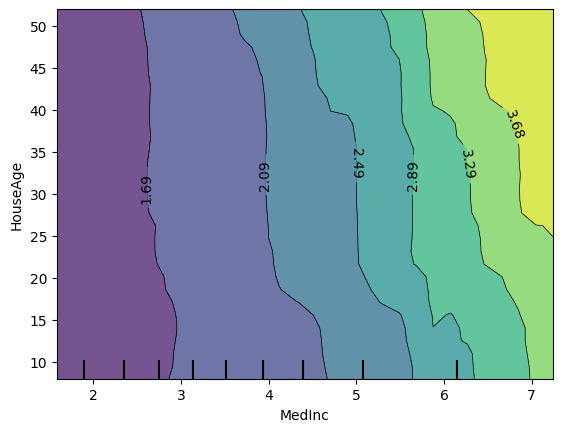

In [19]:
PartialDependenceDisplay.from_estimator(reg, X_test, features=[("MedInc","HouseAge")], kind="average", grid_resolution=30)
plt.show()

### Interprétation

Ce graphique montre la relation entre le revenu médian (MedInc, axe x) et l'âge médian des maisons (HouseAge, axe y).

- **Tendance** : Plus le revenu augmente (de 1 à 4 environ), plus les maisons sont récentes (âge passe de 40 à 25 ans). Les zones riches ont des maisons plus neuves, les zones pauvres ont des maisons plus vieilles.
- **Style** : Une zone colorée (violet à jaune) pour montrer la baisse, avec des valeurs comme 1.69, 2.09, etc., qui marquent des points moyens.
- **Pour la régression** : Cela aide à prédire les prix des maisons. Le revenu est un bon indicateur fort, l'âge un peu moins. Utilisez les deux pour un meilleur modèle.

## C-ICE centered at it's median

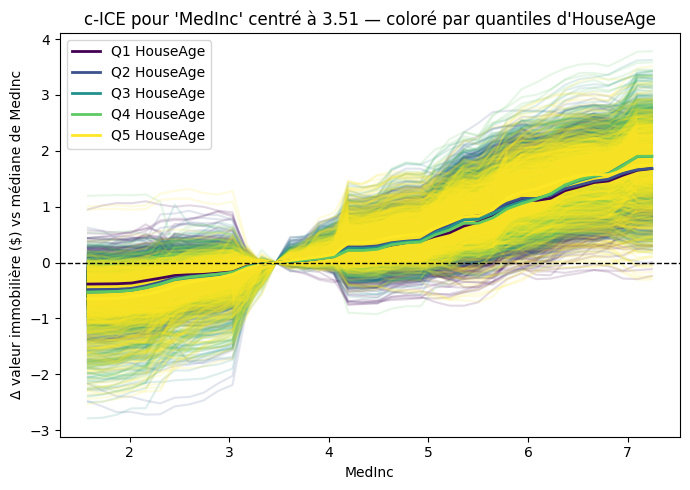

In [20]:
feat = "MedInc"
res = partial_dependence(
    reg, X=X_test, features=[feat],
    kind="individual", grid_resolution=40
)
xs = res.grid_values[0]
lines = res["individual"][0]

# c-ICE: centre chaque courbe à la médiane de 'MedInc'
center_val = X_test[feat].median()
center_idx = np.argmin(np.abs(xs - center_val))
lines_centered = lines - lines[:, [center_idx]]

# Colorer par quantiles de "HouseAge"
house_age = X_test["HouseAge"].astype(float)
groups = pd.qcut(house_age, q=5, labels=False, duplicates="drop")

plt.figure(figsize=(7, 5))
cmap = plt.cm.viridis
for g in np.unique(groups):
    mask = (groups == g).values
    color = cmap(g / np.max(groups))
    plt.plot(xs, lines_centered[mask].T, color=color, alpha=0.15)

# moyenne par groupe (plus lisible)
for g in np.unique(groups):
    mask = (groups == g).values
    color = cmap(g / np.max(groups))
    plt.plot(xs, lines_centered[mask].mean(axis=0), color=color, lw=2, label=f"Q{int(g)+1} HouseAge")

plt.axhline(0, color="k", lw=1, ls="--")
plt.title(f"c-ICE pour '{feat}' centré à {center_val:.2f} — coloré par quantiles d'HouseAge")
plt.xlabel(feat);
plt.ylabel("Δ valeur immobilière ($) vs médiane de MedInc")
plt.legend()
plt.tight_layout()
plt.show()

### Interprétation

Ce graphique montre l'effet du revenu médian (MedInc, axe x) sur la variation de la valeur médiane des maisons (Δ en $, axe y), centré à MedInc = 3.51 (où tout vaut 0). Les lignes sont colorées par quantiles d'âge des maisons (HouseAge) : Q1 (violet, maisons plus récentes) à Q4 (jaune, maisons plus anciennes).

- **Tendance générale** : Plus le revenu augmente, plus la valeur des maisons grimpe (lignes montent à droite). À gauche (bas revenu), la valeur baisse.
- **Interaction** : L'effet varie selon l'âge. Les lignes jaunes (maisons anciennes) montent plus fort à droite (gros gain avec haut revenu) et descendent moins à gauche. Les lignes violettes (maisons récentes) ont un effet plus faible.
- **Pour la régression** : Révèle une interaction entre MedInc et HouseAge. Ajoutez un terme d'interaction dans le modèle pour mieux prédire les prix.

# Récapitulatif des Constats du Projet

Ce projet visait à entraîner un modèle non linéaire sur le dataset Adult Income, puis à utiliser les courbes PDP et ICE pour interpréter son comportement, en insistant sur la différence entre les effets moyens et individuels.

### Modèle Utilisé
Le modèle utilisé est un **XGBoost Classifier**, un modèle d'ensemble puissant et non linéaire, entraîné pour prédire la probabilité qu'un individu gagne plus de 50 000 $ par an.

### Variables Clés Analysées
Les variables clés sélectionnées pour l'analyse PDP et ICE, basées sur leur importance de permutation, sont :
- `age`
- `hoursperweek`
- `education-num`

### Insights des PDP/ICE 1D
- **`age`**: Le PDP a montré une relation non linéaire avec l'âge, avec une probabilité de gagner >50K augmentant initialement, se stabilisant, puis diminuant légèrement. Les courbes ICE individuelles ont révélé une grande variabilité autour de cette moyenne, suggérant que l'effet de l'âge est loin d'être uniforme pour tous les individus.
- **`hoursperweek`**: Le PDP a indiqué une augmentation de la probabilité avec les heures travaillées, atteignant un plateau autour de 40-45 heures, puis une légère baisse ou stabilisation. Les ICE ont montré des comportements très divers, avec certains individus présentant une forte augmentation linéaire, d'autres un plateau plus marqué, et d'autres encore une diminution rapide après le pic, masqués par la moyenne du PDP.
- **`education-num`**: Le PDP a révélé une relation globalement croissante entre le niveau d'éducation (numérique) et la probabilité de gagner >50K$. Les ICE ont également montré une forte hétérogénéité, certains individus ayant un effet d'éducation plus prononcé que d'autres, ou des seuils différents où la probabilité augmente significativement.

### Insights des PDP 2D (Interactions)
Les PDP 2D ont mis en évidence des interactions importantes entre les variables clés :
- **`age` et `hoursperweek`**: L'effet du nombre d'heures travaillées sur la probabilité de haut revenu dépend de l'âge. Par exemple, travailler plus d'heures peut avoir un impact plus prononcé ou différent sur les jeunes adultes en début de carrière par rapport aux travailleurs plus âgés, ou inversement, montrant que la combinaison de ces deux facteurs est plus informative que chacun pris isolément.
- **`education-num` et `hoursperweek`**: Une interaction claire a été observée où le bénéfice marginal d'heures supplémentaires est plus important ou se manifeste différemment selon le niveau d'éducation. Par exemple, pour les personnes avec une éducation supérieure, l'augmentation des heures de travail pourrait entraîner une augmentation plus forte de la probabilité de gagner >50K$ que pour celles avec un niveau d'éducation inférieur.

### Insights des c-ICE (centrés) et Coloration
L'analyse des c-ICE pour `hoursperweek`, centrés à 40 heures et colorés par les quantiles de `education-num`, a été particulièrement révélatrice de l'hétérogénéité :
- En centrant les courbes, nous avons pu mieux comparer les *pentes* et les *formes* des relations individuelles plutôt que leurs niveaux absolus.
- La coloration par `education-num` a clairement montré que l'effet de `hoursperweek` n'est pas uniforme mais varie considérablement en fonction du niveau d'éducation. Des groupes d'individus avec différents niveaux d'éducation (différentes couleurs) ont affiché des trajectoires très distinctes par rapport aux heures travaillées, prouvant que l'éducation agit comme un modérateur important de l'effet des heures. Ces différences auraient été complètement masquées par un PDP 1D seul.

### Conclusion Principale
Les **Partial Dependence Plots (PDP)** fournissent une excellente vue d'ensemble de l'effet moyen d'une ou deux variables sur la prédiction du modèle. Cependant, parce qu'ils agrègent les comportements, ils peuvent **lisser ou masquer des effets hétérogènes et des interactions complexes**. Les **Individual Conditional Expectation (ICE) plots**, en revanche, révèlent la diversité des comportements individuels du modèle. Lorsque les ICE sont **centrés (c-ICE)** ou **colorés par les valeurs d'une autre variable**, ils deviennent des outils puissants pour mettre en évidence les hétérogénéités, les interactions cachées et les différences de comportement selon les sous-groupes, ce qui est crucial pour une interprétation fine et nuancée des prédictions d'un modèle non linéaire.